### Multivariate Time Series Prediction Based on Optimized Temporal Convolutional Networks with Stacked Auto-encoders

The overall framework of the proposed model SAEs-BO-TCN is presented in Figure 1.

The model is divided into four phases. 
1. The first is the feature extraction stage. The original multivariate time series is input to the SAEs to obtain the reduced dimensions of reconstructed time series. The last hidden layer serves as the new feature representation
of the original time series. 
2. In the second phase, we split the data set into fixed length subsequences using a time window of size T with sliding step S shown in Figure 2
3. In the third stage, the split time series is fed to TCN to train the prediction model.
4. Finally, we apply the Bayesian optimization to search for the optimal hyperparameters of TCN and multiple searchers with specific search strategy are set to efficiently search theentire hyperparameter space in parallel. 

Through the above four stages, we can train a deep neural network to make the p-step-ahead prediction


<img src="./Data/architecture.png" />

<img src="./Data/tcn_arch.png" />

In [1]:
import pandas as pd
# import modin.pandas as pd
import matplotlib
import numpy as np
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler
from pandas_profiling import ProfileReport
from datetime import datetime,timedelta
from matplotlib import pyplot as plt
from keras.utils import np_utils
from tensorflow import keras
import seaborn as sns
from pylab import rcParams

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

import random
%matplotlib inline

Using TensorFlow backend.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU');
tf.config.experimental.set_memory_growth(gpus[0], True);

In [3]:
sns.set(style='whitegrid', palette='gist_heat', font_scale=1.5)
rcParams['figure.figsize'] = 20,8

### Data Desc

### Load data

In [4]:
data = pd.read_csv("./Data/PRSA_data_2010.1.1-2014.12.31.csv")
data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


### Preprocessing

### Timestamps as indices (drop year,month,day columns)

In [5]:
# data["timestamp"] = datetime(data["year"],data["month"],data["day"],data["hour"])
data["timestamp"] = data.apply(lambda df:datetime(df["year"],df["month"],df["day"],df["hour"]), axis=1)
data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,timestamp
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00


In [6]:
data.drop(["No","year","month","day","hour"],axis=1,inplace=True)
data.set_index("timestamp",inplace=True)
print(data.shape)
data.head()

(43824, 8)


,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
timestamp,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DAF62B5448>,
      dtype=object)

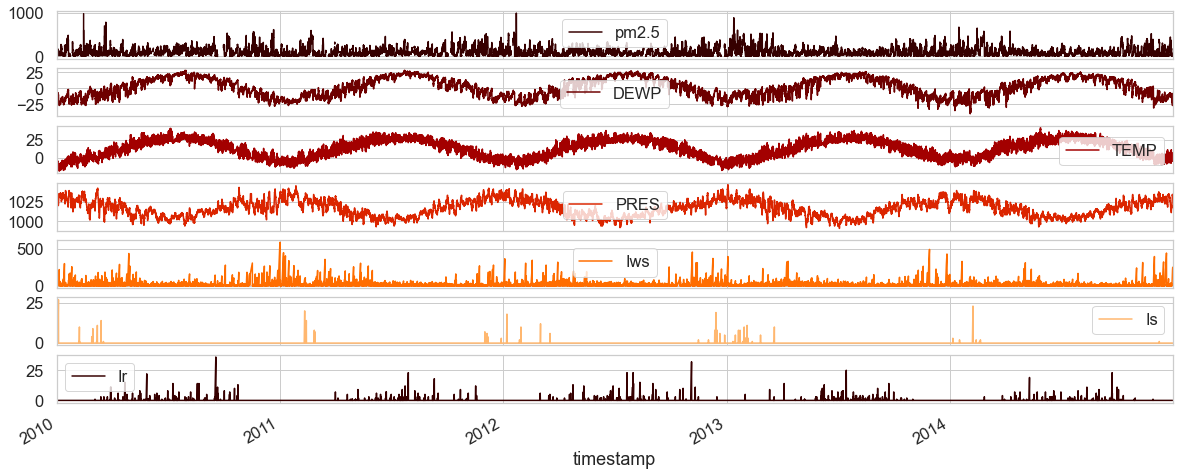

In [7]:
data.plot(subplots=True)

In [8]:
profile = ProfileReport(data, title="Pandas Profiling Report")

In [9]:
# profile.to_widgets()

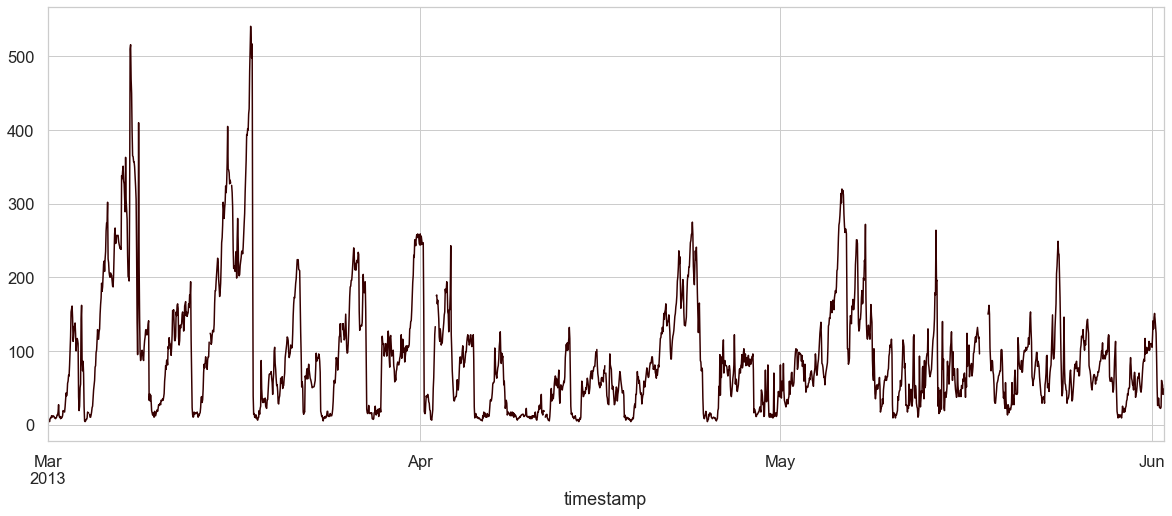

In [10]:
# data["pm2.5"]["2013-01-01":"2013-02-28"].plot()
data["pm2.5"]["2013-03-01":"2013-06-01"].plot()

### Handling missing values

In [11]:
# Col: pm2.5

# data[data["pm2.5"].isnull()].index.tolist()

# interpolate
data["pm2.5"] = data["pm2.5"].interpolate()
# data["pm2.5"].interpolate().value_counts(dropna=False)

# Interpolate missing values
# df.interpolate(limit=1, limit_direction='forward')

# This replaces with same values
# Forward-fill 
# data["pm2.5"] = data["pm2.5"].ffill()
# data["pm2.5"].ffill().value_counts(dropna=False)

# Back-fill
# data["pm2.5"] =  data["pm2.5"].bfill()
# data["pm2.5"].bfill().value_counts(dropna=False)



In [12]:
# Helper functions
def plot_days_data(data,
                   column, 
                   year, month, day, hour_start,hour_end,
                   no_of_days):
    fig, axs = plt.subplots(nrows=no_of_days, ncols=1, figsize=(int(3)*4, int(3)))
    start_date = datetime(year,month,day,hour_start)
    end_date = datetime(year,month,day,hour_end)
    for i in range(no_of_days):
        s_dt = str(start_date + timedelta(days=i))
        e_dt = str(end_date + timedelta(days=i))
        axs[i].plot(data[column][s_dt:e_dt])
    plt.subplots_adjust(hspace=1.000)
    plt.show()

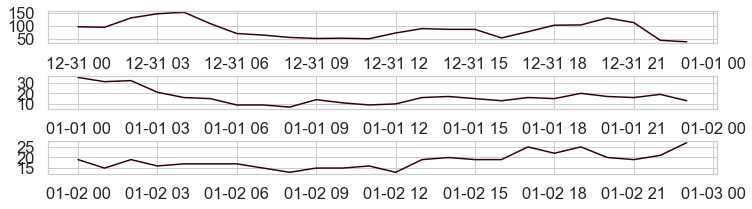

In [13]:
plot_days_data(data,"pm2.5",2012,12,31,0,23,3)

In [14]:
data["pm2.5"][data["pm2.5"].isnull()]

timestamp
2010-01-01 00:00:00   NaN
2010-01-01 01:00:00   NaN
2010-01-01 02:00:00   NaN
2010-01-01 03:00:00   NaN
2010-01-01 04:00:00   NaN
2010-01-01 05:00:00   NaN
2010-01-01 06:00:00   NaN
2010-01-01 07:00:00   NaN
2010-01-01 08:00:00   NaN
2010-01-01 09:00:00   NaN
2010-01-01 10:00:00   NaN
2010-01-01 11:00:00   NaN
2010-01-01 12:00:00   NaN
2010-01-01 13:00:00   NaN
2010-01-01 14:00:00   NaN
2010-01-01 15:00:00   NaN
2010-01-01 16:00:00   NaN
2010-01-01 17:00:00   NaN
2010-01-01 18:00:00   NaN
2010-01-01 19:00:00   NaN
2010-01-01 20:00:00   NaN
2010-01-01 21:00:00   NaN
2010-01-01 22:00:00   NaN
2010-01-01 23:00:00   NaN
Name: pm2.5, dtype: float64

In [15]:
# drop null data

data.dropna(inplace=True)

### Categorical variables- hot-encoded 
 Convert categorical variable into dummy/indicator variables.


In [16]:
data.cbwd.unique().tolist()

['SE', 'cv', 'NW', 'NE']

In [17]:
df_dummies = pd.get_dummies(data, columns=['cbwd'])

In [18]:
df_dummies.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
timestamp,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


In [19]:
df_dummies.shape

(43800, 11)

In [20]:
orig_column_list = df_dummies.columns
orig_column_list

Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NE',
       'cbwd_NW', 'cbwd_SE', 'cbwd_cv'],
      dtype='object')

### Normalize using z-score

In [21]:
list_cols = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
scaler = StandardScaler()
scaler.fit(df_dummies[list_cols])
df_dummies[list_cols] = scaler.transform(df_dummies[list_cols])

# scaler = StandardScaler()
# scaler.fit(df_dummies)
# df_dummies = scaler.transform(df_dummies)
# df_dummies = pd.DataFrame(df_dummies,columns=orig_column_list)
df_dummies.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
timestamp,,,,,,,,,,,
2010-01-02 00:00:00,0.338094,-1.235589,-1.349849,0.345886,-0.441890,-0.069372,-0.137706,0,0,1,0
2010-01-02 01:00:00,0.546963,-1.166285,-1.349849,0.345886,-0.424098,-0.069372,-0.137706,0,0,1,0
2010-01-02 02:00:00,0.667888,-0.889069,-1.431862,0.443244,-0.406306,-0.069372,-0.137706,0,0,1,0
2010-01-02 03:00:00,0.909736,-0.611852,-1.431862,0.540603,-0.370522,1.245425,-0.137706,0,0,1,0
2010-01-02 04:00:00,0.437032,-0.611852,-1.431862,0.540603,-0.352730,2.560223,-0.137706,0,0,1,0


### Modelling

#### Divide the data

In [22]:
train_cols = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NE','cbwd_NW', 'cbwd_SE', 'cbwd_cv']
pred_col = 'pm2.5'

len_orig = len(df_dummies)
len_train = int(len(df_dummies)*0.6)
len_val = int(len(df_dummies)*0.8)
# len(x_train)+len(x_val)+len(x_test)

 
# x_train,y_train = df_dummies[train_cols].iloc[0:len_train],df_dummies[pred_col].iloc[0:len_train]
# x_val,y_val = df_dummies[train_cols].iloc[len_train:len_val],df_dummies[pred_col].iloc[len_train:len_val]
# x_test,y_test = df_dummies[train_cols].iloc[len_val:len_orig],df_dummies[pred_col].iloc[len_val:len_orig]

# split whole dataset 
df_train = df_dummies.iloc[0:len_train]
df_val = df_dummies.iloc[len_train:len_val]
df_test = df_dummies.iloc[len_val:len_orig]

# split x and y
x_train,y_train = df_train[train_cols], df_train[pred_col]
x_val,y_val = df_val[train_cols], df_val[pred_col]
x_test,y_test = df_test[train_cols], df_test[pred_col]


In [23]:
x_train.shape

(26280, 10)

### 1. Stacked autoencoder
The first is the feature extraction stage. The original multivariate time series is input to the SAEs to obtain the reduced dimensions of reconstructed time series. The last hidden layer serves as the new feature representation of the original time series.

In [24]:
x_train.shape

(26280, 10)

In [35]:
# encoder
inputs = keras.Input(shape=x_train.shape[1])
# lr_flatten = keras.layers.Flatten()(inputs)
lr1 = keras.layers.Dense(9, activation="relu")(inputs)
lr2 = keras.layers.Dense(7, activation="relu")(lr1)
lr3 = keras.layers.Dense(6, activation="relu")(lr2)
lr4 = keras.layers.Dense(5, activation="relu")(lr3)

# #decoder 
lr5 = keras.layers.Dense(6, activation="relu")(lr4)
lr6 = keras.layers.Dense(7, activation="relu")(lr5)
lr7 = keras.layers.Dense(9, activation="relu")(lr6)
lr8 = keras.layers.Dense(x_train.shape[1], activation="sigmoid")(lr7)

# outputs = keras.layers.Reshape([windows_train.shape[1],windows_train.shape[2]])(lr6)

encoded_model = keras.models.Model(inputs,lr4)

stacked_ae = keras.models.Model(inputs, lr8)
stacked_ae.summary()


Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_58 (Dense)             (None, 9)                 99        
_________________________________________________________________
dense_59 (Dense)             (None, 7)                 70        
_________________________________________________________________
dense_60 (Dense)             (None, 6)                 48        
_________________________________________________________________
dense_61 (Dense)             (None, 5)                 35        
_________________________________________________________________
dense_62 (Dense)             (None, 6)                 36        
_________________________________________________________________
dense_63 (Dense)             (None, 7)                 49 

In [36]:
nb_epoch = 60
batch_size = 32

model_path = "./models/sae_final_model.h5"

# stacked_ae.compile(loss="mse",optimizer=keras.optimizers.SGD(lr=1.5))
optimizer= keras.optimizers.Adam(learning_rate=0.006)
stacked_ae.compile(optimizer= optimizer, 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath= model_path,
                               verbose=0,
                               save_best_only=True)
# patient early stopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='min', restore_best_weights=True)
                #EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
history = stacked_ae.fit(x_train, x_train,
                         epochs=nb_epoch,
#                          shuffle=True,
                         validation_data=(x_val,x_val),
                         verbose=1,
                         callbacks=[checkpointer,early_stopping]
                        ).history



Train on 26280 samples, validate on 8760 samples
Epoch 1/60
26280/26280 [==============================] - 4s 152us/sample - loss: 0.5507 - accuracy: 0.4255 - val_loss: 0.3551 - val_accuracy: 0.5616
Epoch 2/60
26280/26280 [==============================] - 3s 132us/sample - loss: 0.4815 - accuracy: 0.6101 - val_loss: 0.3394 - val_accuracy: 0.6164
Epoch 3/60
26280/26280 [==============================] - 4s 140us/sample - loss: 0.4742 - accuracy: 0.6137 - val_loss: 0.3254 - val_accuracy: 0.6582
Epoch 4/60
26280/26280 [==============================] - 4s 137us/sample - loss: 0.4639 - accuracy: 0.6221 - val_loss: 0.3240 - val_accuracy: 0.6400
Epoch 5/60
26280/26280 [==============================] - 4s 136us/sample - loss: 0.4629 - accuracy: 0.6059 - val_loss: 0.3237 - val_accuracy: 0.5949
Epoch 6/60
26280/26280 [==============================] - 4s 136us/sample - loss: 0.4627 - accuracy: 0.5885 - val_loss: 0.3228 - val_accuracy: 0.5918
Epoch 7/60
26280/26280 [===========================

Epoch 55/60
26280/26280 [==============================] - 3s 133us/sample - loss: 0.4597 - accuracy: 0.5139 - val_loss: 0.3168 - val_accuracy: 0.5396
Epoch 56/60
26280/26280 [==============================] - 4s 136us/sample - loss: 0.4565 - accuracy: 0.5244 - val_loss: 0.3168 - val_accuracy: 0.5503
Epoch 57/60
26280/26280 [==============================] - 4s 137us/sample - loss: 0.4562 - accuracy: 0.5148 - val_loss: 0.3164 - val_accuracy: 0.5446
Epoch 58/60
26280/26280 [==============================] - 4s 137us/sample - loss: 0.4567 - accuracy: 0.5113 - val_loss: 0.3172 - val_accuracy: 0.5120
Epoch 59/60
26280/26280 [==============================] - 4s 134us/sample - loss: 0.4565 - accuracy: 0.4999 - val_loss: 0.3163 - val_accuracy: 0.5277
Epoch 60/60
26280/26280 [==============================] - 4s 134us/sample - loss: 0.4586 - accuracy: 0.5047 - val_loss: 0.3165 - val_accuracy: 0.5432


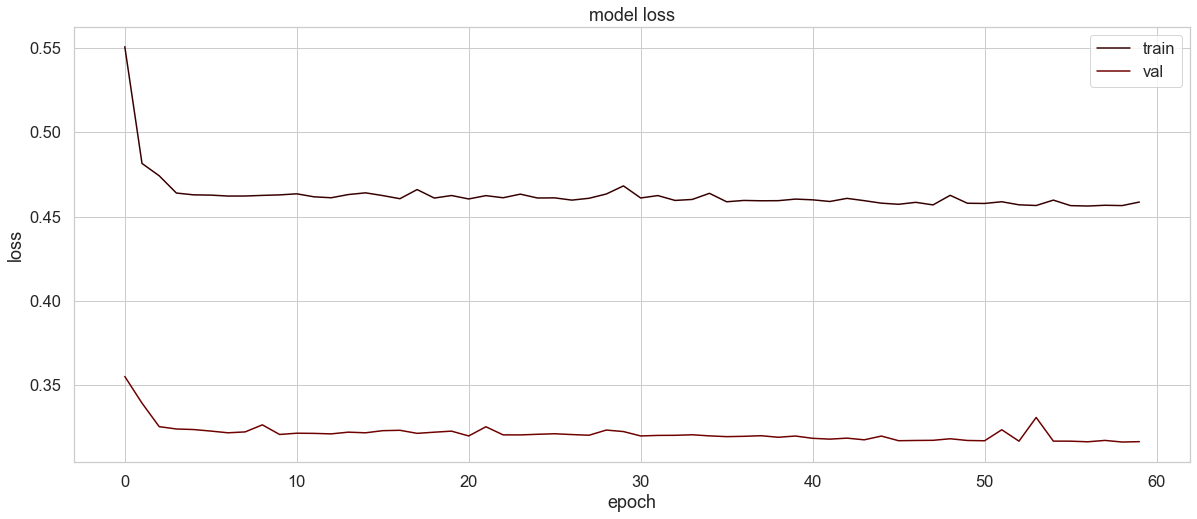

In [37]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right');
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DAAFD32BC8>,
      dtype=object)

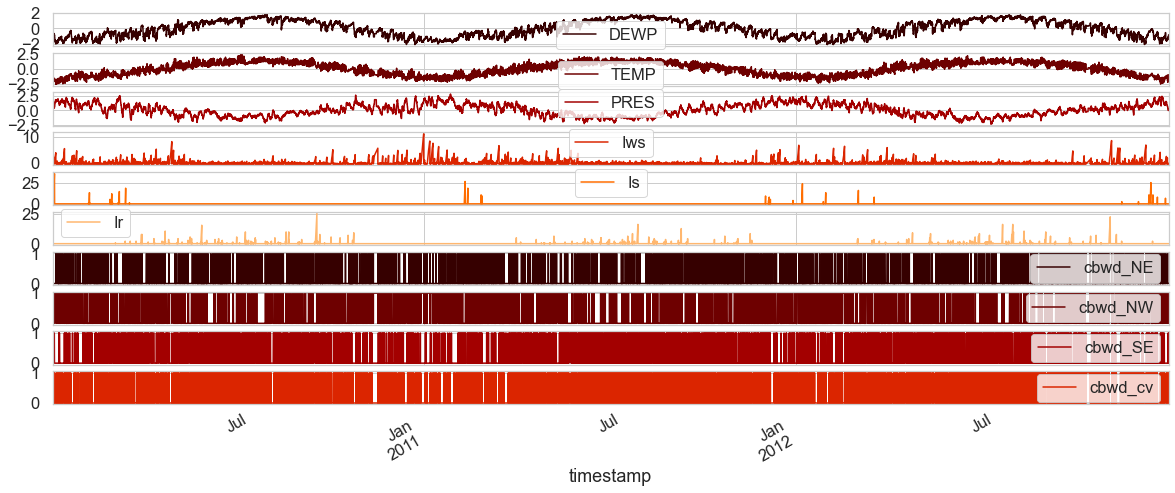

In [38]:
x_train.plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DAB130FEC8>,
      dtype=object)

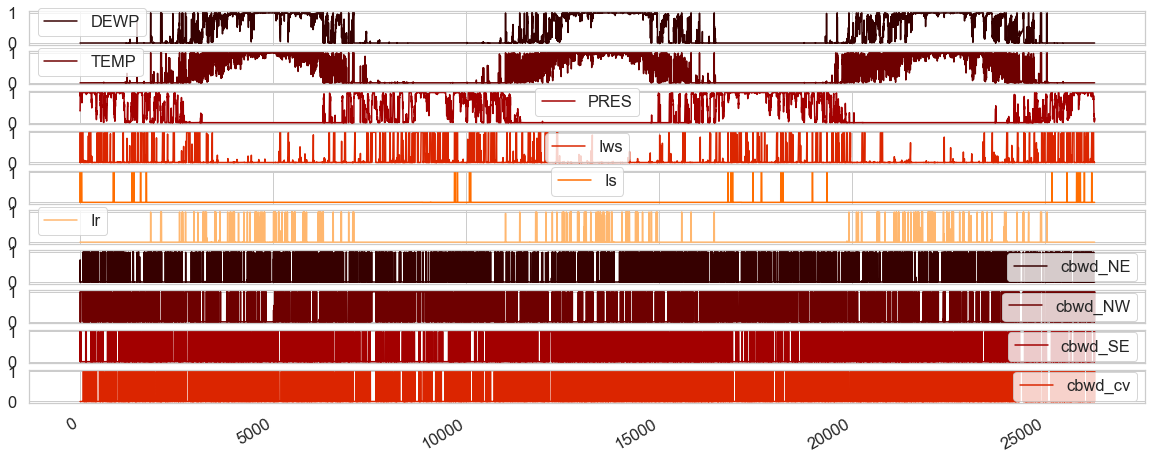

In [39]:
# predicted plotting
pd.DataFrame(stacked_ae.predict(x_train),columns=train_cols).plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DAB12C1A88>,
      dtype=object)

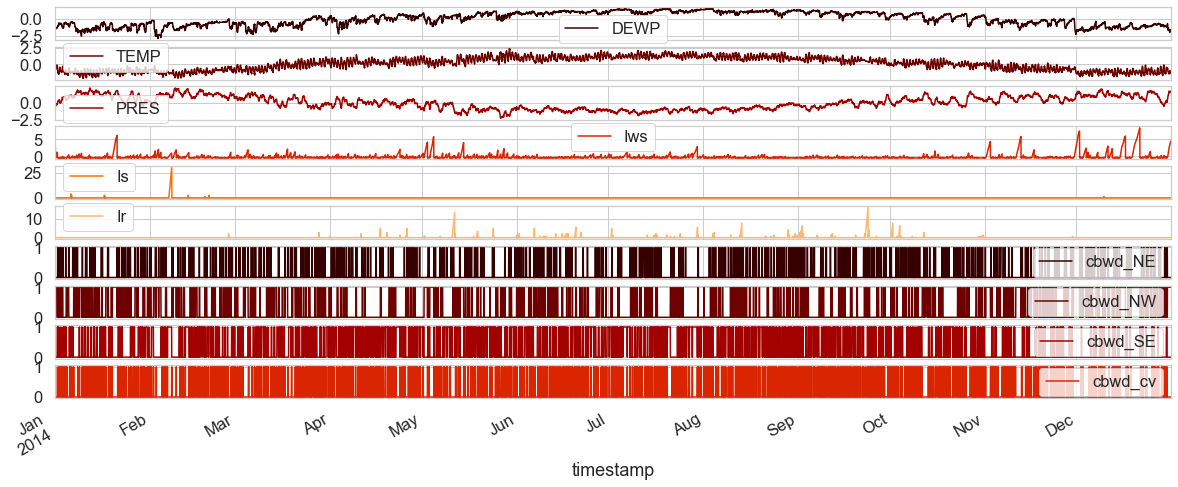

In [40]:
x_test.plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DAB5940288>,
      dtype=object)

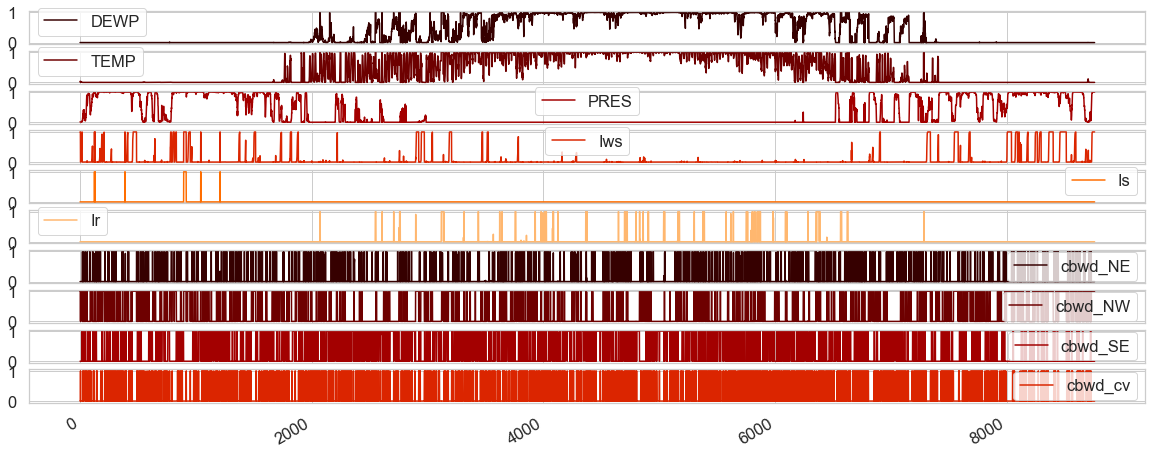

In [41]:
# predicted plotting
pd.DataFrame(stacked_ae.predict(x_test),columns=train_cols).plot(subplots=True)

### Extract feature vector from the encoder

In [42]:
x_train_feature_ = encoded_model.predict(x_train)
x_val_feature_ = encoded_model.predict(x_val)
print(x_train_feature_.shape,x_val_feature_.shape)

(26280, 5) (8760, 5)


In [43]:
stacked_ae.predict(x_test).shape, encoded_model.predict(x_test).shape 

((8760, 10), (8760, 5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DAB6F39108>,
      dtype=object)

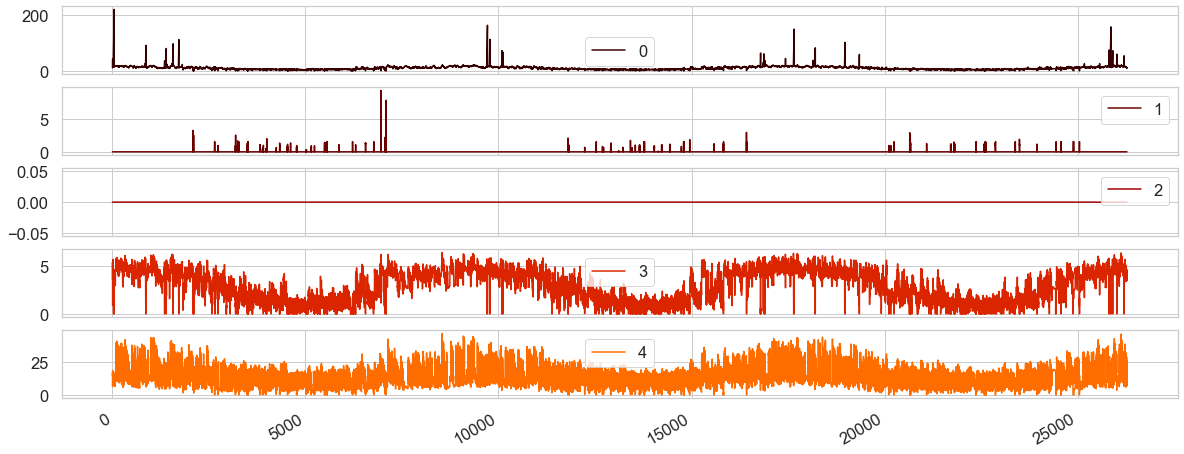

In [44]:
# endoded feature vector (latent space)
encoded_model.predict(x_train).shape
pd.DataFrame(encoded_model.predict(x_train)).plot(subplots = True)

### 2. Windowing for input to the TCN
In the second phase, we split the data set into fixed length subsequences using a time window of size T with sliding step S shown in Figure 2

In [99]:
n_steps_in = seq_size=  229
n_steps_out = HORIZON = 1 #24*21 # Prediction horizon = 21 days

#### Multiple input multi step output

In [105]:
# https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/
# split a multivariate sequence into samples
def split_sequences_in_out(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [106]:
df_extracted = pd.DataFrame(encoded_model.predict(x_train))
df_extracted[pred_col] = df_train[pred_col].values
# df_extracted.head()

In [107]:
df_train.shape,x_train.shape,df_extracted.shape

((26280, 11), (26280, 10), (26280, 6))

In [108]:
X_extracted_train, y_extracted_train = split_sequences_in_out(df_extracted.values, n_steps_in,n_steps_out)

print(X_extracted_train.shape, y_extracted_train.shape)


(26052, 229, 5) (26052, 1)


In [109]:
# Val data
df_val_extracted = pd.DataFrame(encoded_model.predict(x_val))
df_val_extracted[pred_col] = df_val[pred_col].values

# Test data
df_test_extracted = pd.DataFrame(encoded_model.predict(x_test))
df_test_extracted[pred_col] = df_test[pred_col].values

X_val_extracted, y_val_extracted = split_sequences_in_out(df_val_extracted.values, n_steps_in,n_steps_out)
X_test_extracted, y_test_extracted = split_sequences_in_out(df_test_extracted.values, n_steps_in,n_steps_out)

### 3. TCN
In the third stage, the split time series is fed to TCN to train the prediction model.

### Dilated Convnet

In [110]:
# OR
# source https://github.com/jeffheaton/t81_558_deep_learning/blob/1f16da595603d04ee86e48b134c62e3f2f6603b2/t81_558_class_10_5_temporal_cnn.ipynb

In [111]:
# kernel_contraint = range(2,12)
# dropout_constraint = np.arange(0.1,0.5,0.01)

n_features = X_extracted_train.shape[2] 
HORIZON = n_steps_out # prediction horizon = 1hour for 7 days Horizon = 7*24

# using optimized results 
lr = 0.006
dropout = 0.32 
seq_size =  229 
kernel_size = 10
hidden_units = 60
hidden_layers = 10

print(f"sequence_size: {seq_size} \nkernel_size: {kernel_size} \ndropout_rate: {dropout} \nn_features: {n_features} \nprediction_horizon : {HORIZON}")

sequence_size: 229 
kernel_size: 10 
dropout_rate: 0.32 
n_features: 5 
prediction_horizon : 1


In [115]:
print('Build model...')
tcn = Sequential()

tcn.add(Conv1D(filters=60, 
                 kernel_size=kernel_size, 
                 padding='causal', 
                 strides=1, 
                 activation='relu', 
                 dilation_rate=1, 
                 input_shape=(seq_size,n_features)))
tcn.add(Dropout(dropout))
tcn.add(Conv1D(filters=60, 
                 kernel_size=kernel_size, 
                 padding='causal', 
                 strides=1, 
                 activation='relu', 
                 dilation_rate=2))
tcn.add(Dropout(dropout))
tcn.add(Conv1D(filters=60, 
                 kernel_size=kernel_size, 
                 padding='causal', 
                 strides=1, 
                 activation='relu', 
                 dilation_rate=4))
tcn.add(Dropout(dropout))
tcn.add(Conv1D(filters=60, 
                 kernel_size=kernel_size, 
                 padding='causal', 
                 strides=1, 
                 activation='relu', 
                 dilation_rate=8))
tcn.add(Dropout(dropout))

tcn.add(Flatten())
# tcn.add(Dense(50, activation='relu'))
tcn.add(Dense(HORIZON, activation='linear'))
# tcn_model.add(Dense(1))

tcn.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=15, verbose=1, mode='auto', restore_best_weights=True)


Build model...


In [116]:
tcn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 229, 60)           3060      
_________________________________________________________________
dropout_8 (Dropout)          (None, 229, 60)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 229, 60)           36060     
_________________________________________________________________
dropout_9 (Dropout)          (None, 229, 60)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 229, 60)           36060     
_________________________________________________________________
dropout_10 (Dropout)         (None, 229, 60)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 229, 60)          

In [117]:
print('Train...')

tcn.fit(X_extracted_train,y_extracted_train,     #x_train_feature_windowed,y_train,
        validation_data=(X_val_extracted,y_val_extracted),  #x_val_feature_windowed,y_val),
        callbacks=[monitor],
        verbose=1,epochs=50)

Train...
Train on 26052 samples, validate on 8532 samples
Epoch 1/50
26052/26052 [==============================] - 13s 505us/sample - loss: 1.0292 - val_loss: 1.1598
Epoch 2/50
26052/26052 [==============================] - 12s 463us/sample - loss: 0.8362 - val_loss: 0.8505
Epoch 3/50
26052/26052 [==============================] - 12s 468us/sample - loss: 0.6827 - val_loss: 0.8948
Epoch 4/50
26052/26052 [==============================] - 12s 466us/sample - loss: 0.6198 - val_loss: 0.8046
Epoch 5/50
26052/26052 [==============================] - 12s 464us/sample - loss: 0.5658 - val_loss: 0.8055
Epoch 6/50
26052/26052 [==============================] - 12s 472us/sample - loss: 0.5168 - val_loss: 0.8010
Epoch 7/50
26052/26052 [==============================] - 12s 464us/sample - loss: 0.4700 - val_loss: 0.8053
Epoch 8/50
26052/26052 [==============================] - 12s 464us/sample - loss: 0.4470 - val_loss: 0.8374
Epoch 9/50
26052/26052 [==============================] - 12s 470us/sa

###### Predict on train data

In [118]:
yhat_train = tcn.predict(X_extracted_train, verbose=0)
test_ = hstack((y_extracted_train.reshape(-1,1), yhat_train))
test_df = pd.DataFrame(test_,columns=["actual","predicted"])
test_df.head()

,actual,predicted
0,-0.783205,-0.877286
1,-0.772212,-0.820895
2,-0.915122,-0.717992
3,-0.816184,-0.596079
4,-0.937109,-0.475681


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DB2C260AC8>,
      dtype=object)

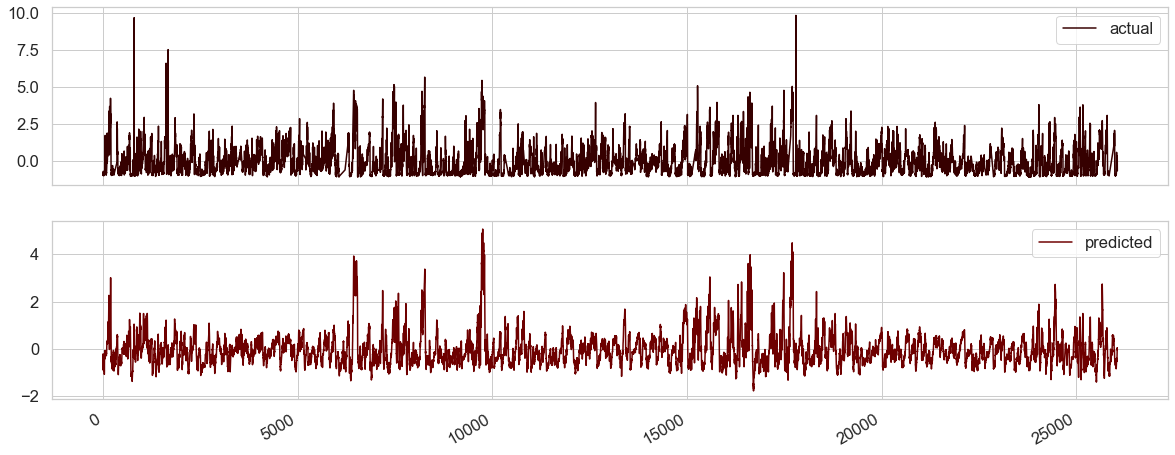

In [119]:
test_df.plot(subplots=True)

#### Predict on val data

In [120]:
X_val_extracted, y_val_extracted = split_sequences(df_val_extracted.values, n_steps)
# yhat_val = tcn.predict(X_val_extracted, verbose=0)
yhat_val = tcn.predict(X_val_extracted, verbose=0)
test_ = hstack((y_val_extracted.reshape(-1,1), yhat_val))
test_df = pd.DataFrame(test_,columns=["actual","predicted"])
test_df.head()

,actual,predicted
0,-0.156597,0.002072
1,-0.013686,0.087591
2,0.140218,0.246602
3,0.755833,0.376187
4,1.987063,0.450241


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DAAFF101C8>,
      dtype=object)

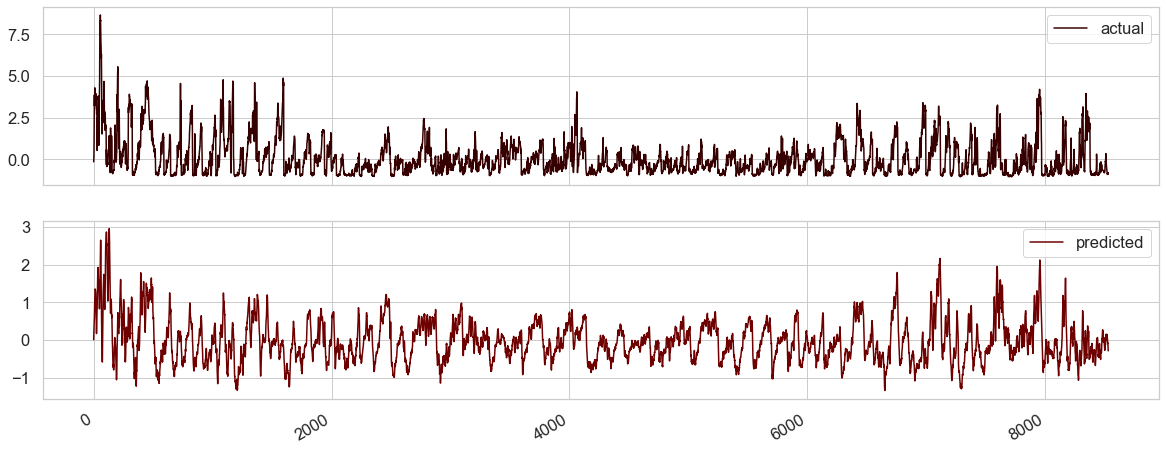

In [121]:
test_df.plot(subplots=True)

###### Predict on test data

In [122]:
# demonstrate  prediction for whole test data
df_test_extracted = pd.DataFrame(encoded_model.predict(x_test))
df_test_extracted[pred_col] = df_test[pred_col].values
print(df_test_extracted.head())

X_test_extracted, y_test_extracted = split_sequences(df_test_extracted.values, n_steps)

yhat_test = tcn.predict(X_test_extracted, verbose=0)
# print(yhat_test)

           0    1    2         3          4     pm2.5
0  11.250736  0.0  0.0  2.468754   3.907744 -0.816184
1  10.922207  0.0  0.0  2.447679   3.787121 -0.497384
2  10.933528  0.0  0.0  2.448446   3.791363 -0.365466
3  10.936423  0.0  0.0  2.448651   3.792467 -0.310500
4   9.229628  0.0  0.0  4.501756  27.628695 -0.211562


In [123]:
test_ = hstack((y_test_extracted.reshape(-1,1), yhat_test))
test_df = pd.DataFrame(test_,columns=["actual","predicted"])
test_df.head()

,actual,predicted
0,-0.321494,-0.138590
1,-0.354473,-0.121402
2,-0.387452,-0.056169
3,-0.607315,-0.059892
4,-0.552349,-0.032915


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DAB0038F88>,
      dtype=object)

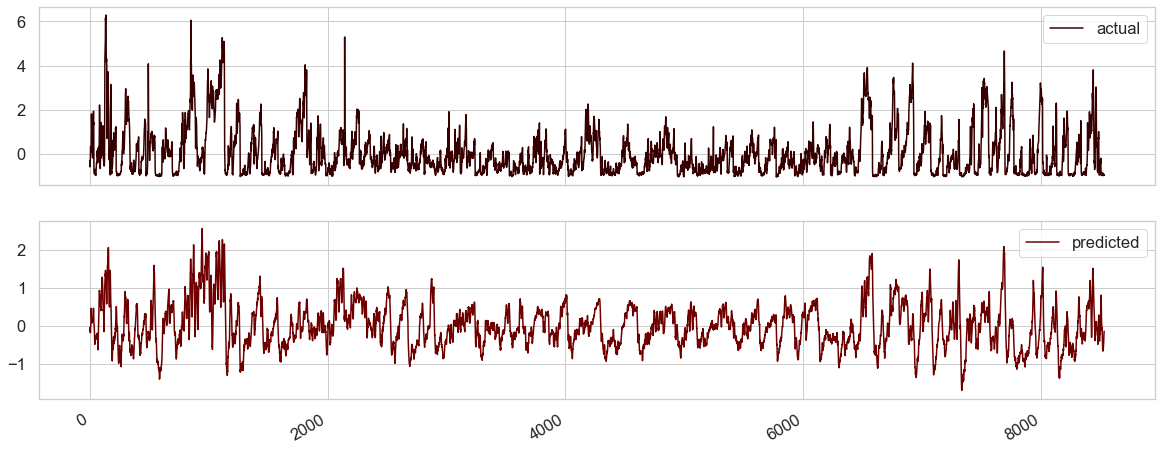

In [124]:
test_df.plot(subplots=True)

### TCN using library

In [1]:
# https://github.com/philipperemy/keras-tcn

In [85]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model

from tcn import TCN, tcn_full_summary

batch_size, timesteps, input_dim = None, seq_size, n_features

In [125]:
i = Input(batch_shape=(batch_size, timesteps, input_dim))

o = TCN(nb_filters=60, kernel_size=kernel_size, nb_stacks=1, dilations=[1, 2, 4, 8], 
    padding='causal', use_skip_connections=True, dropout_rate=dropout, return_sequences=False, 
    activation='relu', kernel_initializer='he_normal', use_batch_norm=True)(i)
o = Dense(HORIZON)(o)
m = Model(inputs=[i], outputs=[o])
optimizer = keras.optimizers.Adam(learning_rate=lr)
m.compile(optimizer='adam', loss='mse')

# simple early stopping
monitor = EarlyStopping(monitor='val_loss', #min_delta=1e-3, 
                        patience=15, verbose=1, mode='min', restore_best_weights=True)
mc = ModelCheckpoint('./models/tcn_final.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# Fit the model
tcn_full_summary(m, expand_residual_blocks=True)

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 229, 5)]          0         
_________________________________________________________________
matching_conv1D (Conv1D)     (None, 229, 60)           360       
_________________________________________________________________
activation_62 (Activation)   (None, 229, 60)           0         
_________________________________________________________________
conv1D_0 (Conv1D)            (None, 229, 60)           3060      
_________________________________________________________________
batch_normalization_40 (Batc (None, 229, 60)           240       
_________________________________________________________________
activation_60 (Activation)   (None, 229, 60)           0         
_________________________________________________________________
spatial_dropout1d_40 (Spatia (None, 229, 60)           0  

In [126]:
m.fit(X_extracted_train, y_extracted_train, 
      epochs=50, verbose=1,
      callbacks=[monitor,mc],
      validation_data=(X_val_extracted,y_val_extracted))

Train on 26052 samples, validate on 8532 samples
Epoch 1/50
26016/26052 [============================>.] - ETA: 0s - loss: 1.4274
Epoch 00001: val_loss improved from inf to 0.75985, saving model to ./models/tcn_final.h5
26052/26052 [==============================] - 34s 1ms/sample - loss: 1.4261 - val_loss: 0.7598
Epoch 2/50
26016/26052 [============================>.] - ETA: 0s - loss: 0.6968
Epoch 00002: val_loss improved from 0.75985 to 0.72038, saving model to ./models/tcn_final.h5
26052/26052 [==============================] - 30s 1ms/sample - loss: 0.6972 - val_loss: 0.7204
Epoch 3/50
26016/26052 [============================>.] - ETA: 0s - loss: 0.6135
Epoch 00003: val_loss improved from 0.72038 to 0.71365, saving model to ./models/tcn_final.h5
26052/26052 [==============================] - 31s 1ms/sample - loss: 0.6131 - val_loss: 0.7136
Epoch 4/50
26016/26052 [============================>.] - ETA: 0s - loss: 0.5686
Epoch 00004: val_loss did not improve from 0.71365
26052/2605

In [127]:
tcn_best = keras.models.load_model("./models/tcn_final.h5",
                                   custom_objects={'TCN': TCN})

###### Predict on train data

In [131]:
yhat_train = tcn_best.predict(X_extracted_train, verbose=0)
test_ = hstack((y_extracted_train.reshape(-1,1), yhat_train))
test_df = pd.DataFrame(test_,columns=["actual","predicted"])
test_df.head()

,actual,predicted
0,-0.783205,-0.774963
1,-0.772212,-0.843893
2,-0.915122,-0.957747
3,-0.816184,-0.856079
4,-0.937109,-0.852044


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DC4162A348>,
      dtype=object)

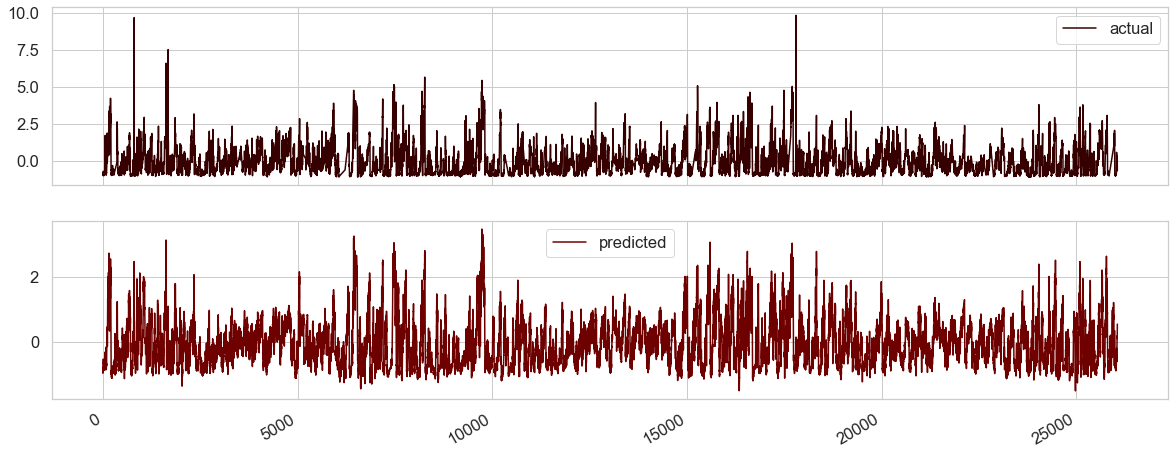

In [132]:
test_df.plot(subplots=True)

#### Predict on val data

In [133]:
X_val_extracted, y_val_extracted = split_sequences(df_val_extracted.values, n_steps)
# yhat_val = tcn.predict(X_val_extracted, verbose=0)
yhat_val = tcn_best.predict(X_val_extracted, verbose=0)
test_ = hstack((y_val_extracted.reshape(-1,1), yhat_val))
test_df = pd.DataFrame(test_,columns=["actual","predicted"])
test_df.head()

,actual,predicted
0,-0.156597,0.658785
1,-0.013686,0.975203
2,0.140218,0.950846
3,0.755833,1.140755
4,1.987063,0.777319


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DC41C9F608>,
      dtype=object)

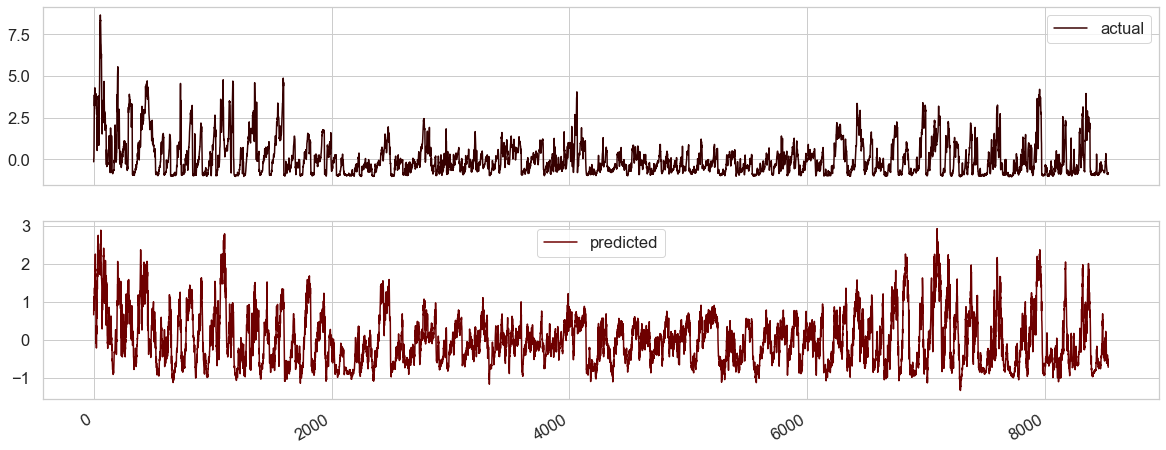

In [134]:
test_df.plot(subplots=True)

###### Predict on test data

In [135]:
# demonstrate  prediction for whole test data
df_test_extracted = pd.DataFrame(encoded_model.predict(x_test))
df_test_extracted[pred_col] = df_test[pred_col].values
print(df_test_extracted.head())

X_test_extracted, y_test_extracted = split_sequences(df_test_extracted.values, n_steps)

yhat_test = tcn_best.predict(X_test_extracted, verbose=0)
# print(yhat_test)

           0    1    2         3          4     pm2.5
0  11.250736  0.0  0.0  2.468754   3.907744 -0.816184
1  10.922207  0.0  0.0  2.447679   3.787121 -0.497384
2  10.933528  0.0  0.0  2.448446   3.791363 -0.365466
3  10.936423  0.0  0.0  2.448651   3.792467 -0.310500
4   9.229628  0.0  0.0  4.501756  27.628695 -0.211562


In [136]:
test_ = hstack((y_test_extracted.reshape(-1,1), yhat_test))
test_df = pd.DataFrame(test_,columns=["actual","predicted"])
test_df.head()

,actual,predicted
0,-0.321494,-0.122861
1,-0.354473,0.118124
2,-0.387452,-0.186973
3,-0.607315,-0.093862
4,-0.552349,-0.360924


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DC41D34AC8>,
      dtype=object)

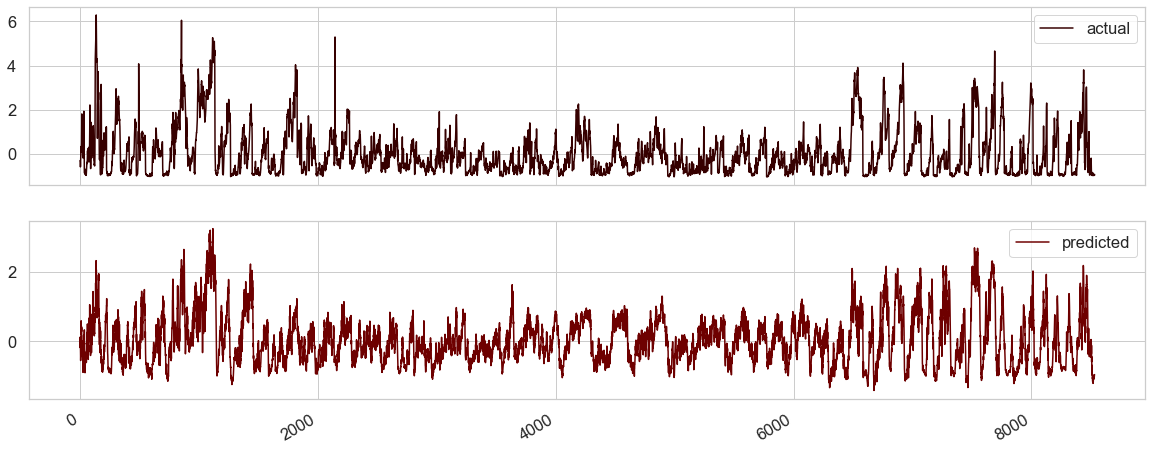

In [137]:
test_df.plot(subplots=True)

#### Use when HORIZON is greater than 1 or in days

In [128]:
# yhat_train = m.predict(X_extracted_train, verbose=0)
y_train_req = y_extracted_train[0].reshape(-1,1)
yhat_train = tcn_best.predict(X_extracted_train[0].reshape(1,n_steps_in,n_features), verbose=0).transpose()
# test_ = hstack((y_train_req, yhat_train))
# test_df = pd.DataFrame(test_,columns=["actual","predicted"])
# test_df.head()

In [129]:
y_train_req.shape,yhat_train.shape

((1, 1), (1, 1))

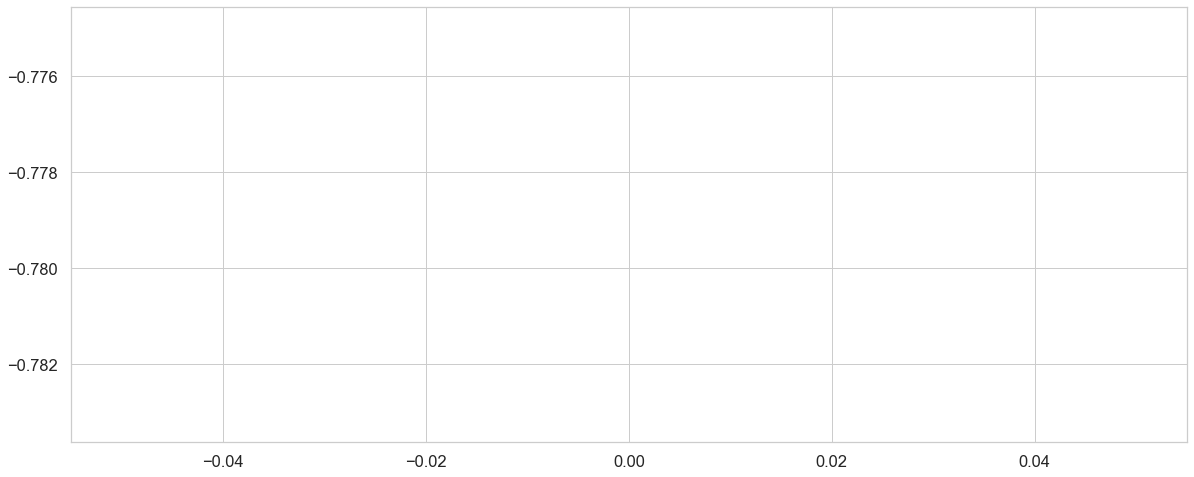

In [130]:
plt.plot(y_train_req)
plt.plot(yhat_train)
    

In [92]:
yactual_val = y_val_extracted[0].reshape(-1,1)
yhat_val = tcn_best.predict(X_val_extracted[0].reshape(1,n_steps_in,n_features), verbose=0).transpose()
yactual_val.shape,yhat_val.shape

((504, 1), (504, 1))

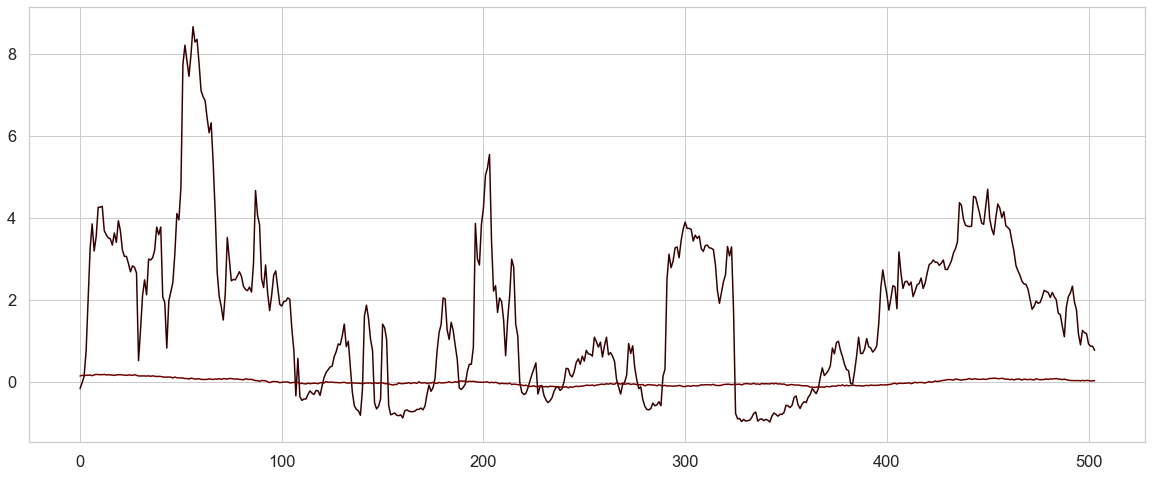

In [93]:
plt.plot(yactual_val)
plt.plot(yhat_val)

In [94]:
yactual_test = y_test_extracted[0].reshape(-1,1)
yhat_test = tcn_best.predict(X_test_extracted[0].reshape(1,n_steps_in,n_features), verbose=0).transpose()
yactual_test.shape,yhat_test.shape

((504, 1), (504, 1))

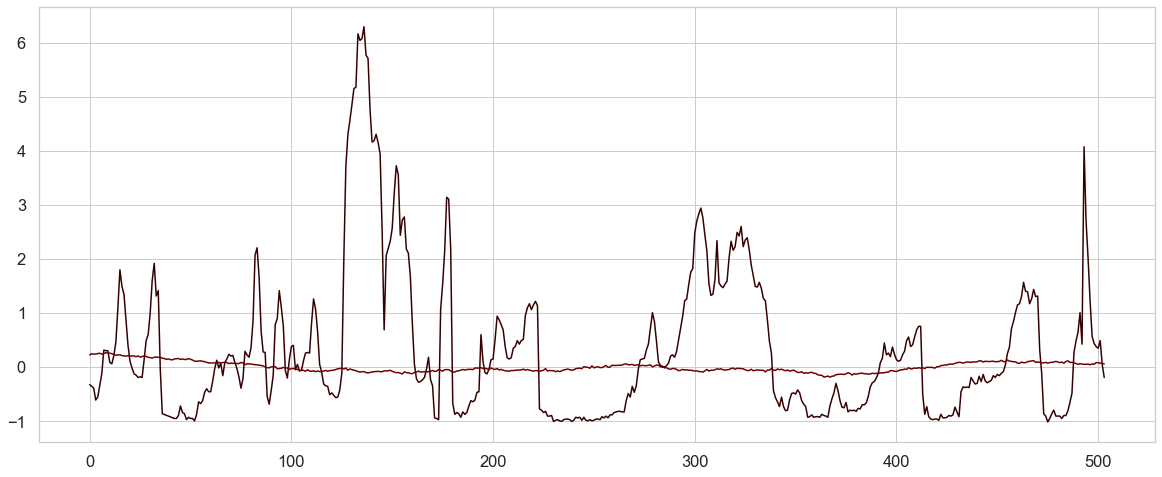

In [95]:
plt.plot(yactual_test)
plt.plot(yhat_test)